# US Flights of 2008
## by (Himanshu Tripathi)

## Investigation Overview

Exploring US flights of 2008 and answering on:-
- what are the best airports/states in terms of delayed and cancelled flighes?
- what are the best airlines in terms of delayed and cancelled flighes?
- what are the best flights in terms of delayed and cancelled flighes?

## Dataset Overview

The dataset reports flights in the United States, including carriers, arrival and departure delays from 1987 to 2008. Actually, the report treated flight details of 2008 which is (7,009,728) observations.

In [0]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from mpl_toolkits.basemap import Basemap
import config
import gmaps
import gmaps.datasets

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [0]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('2008.csv')
df_airports = pd.read_csv('airports.csv')
df_airlines = pd.read_csv('carriers.csv')

In [0]:
df = pd.merge(df, df_airports, left_on='Origin', right_on='iata')

In [0]:

# correcting dates formate
df['DepTime'] = df.DepTime.apply(lambda x: str(int(x)).zfill(4) if pd.notnull(x) else x)
df['CRSDepTime'] = df.CRSDepTime.apply(lambda x: str(int(x)).zfill(4) if pd.notnull(x) else x)
df['ArrTime'] = df.ArrTime.apply(lambda x: str(int(x)).zfill(4) if pd.notnull(x) else x)
df['CRSArrTime'] = df.CRSArrTime.apply(lambda x: str(int(x)).zfill(4) if pd.notnull(x) else x)

In [0]:
def setPM(x):
    if((x>=12) & (x<= 23)):
        return 'PM'
    elif((x>=0) & (x<= 11) | (x==24)):
        return 'AM'
    else:
        return x
    
df.DepTime.dropna(inplace=True)
df['DepTimePM'] = df.DepTime.str[:2].astype('int64')
df['DepTimePM'] = df.DepTimePM.apply(setPM)
df.DepTimePM.dropna(inplace=True)

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Recommended Locations in Terms of Delayed & Cancelled Flights

- The rate of cancelled flights is high in `Pierre Regional Airport`, `Pueblo Memorial Airport` & `Tupelo Regional Airport`. 
- The rate of delayed departures is distributed in whole US. 
- The rate of delayed arrivals is high in `Pueblo Memorial Airport`.

In [0]:
df_mean = df.groupby('iata', as_index=False).mean()
df_mean = df_mean[['iata','ArrDelay','DepDelay','Cancelled']]
df_mean = pd.merge(df_mean, df_airports, on='iata')

In [0]:
df_DepDelay = df_mean[df_mean.DepDelay>=0]
df_ArrDelay = df_mean[df_mean.ArrDelay>=0]
df_Ceancelled = df_mean[df_mean.Cancelled>=0]

In [0]:
locations = df_Ceancelled[['lat', 'long']]
weights = df_Ceancelled['Cancelled']
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights))
fig

Figure(layout=FigureLayout(height='420px'))

### Distribution of Cancelled Flights
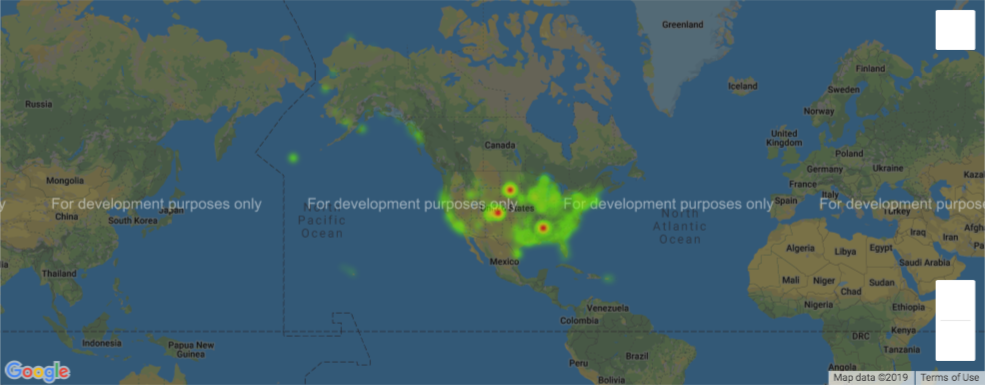

In [0]:

gmaps.configure(api_key=config.api_key)

locations = df_DepDelay[['lat', 'long']]
weights = df_DepDelay['DepDelay']
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights))
fig

Figure(layout=FigureLayout(height='420px'))

### Distribution of Delay (Departure)
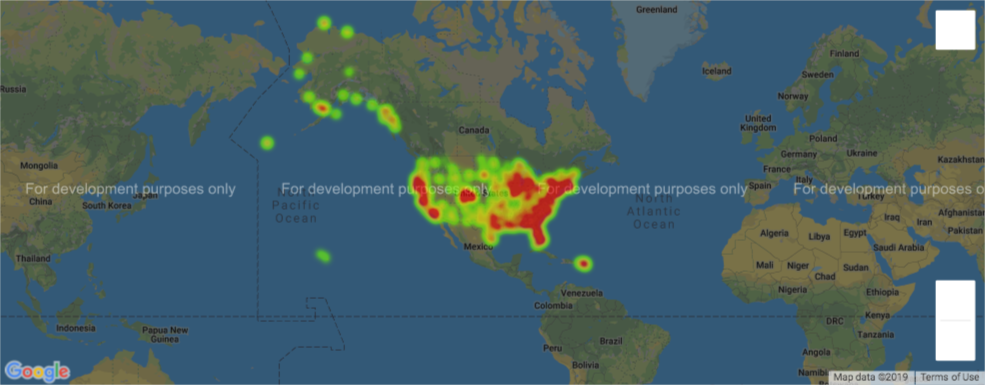

In [0]:
locations = df_ArrDelay[['lat', 'long']]
weights = df_ArrDelay['ArrDelay']
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights))
fig

Figure(layout=FigureLayout(height='420px'))

### Distribution of Delay (Arrival)

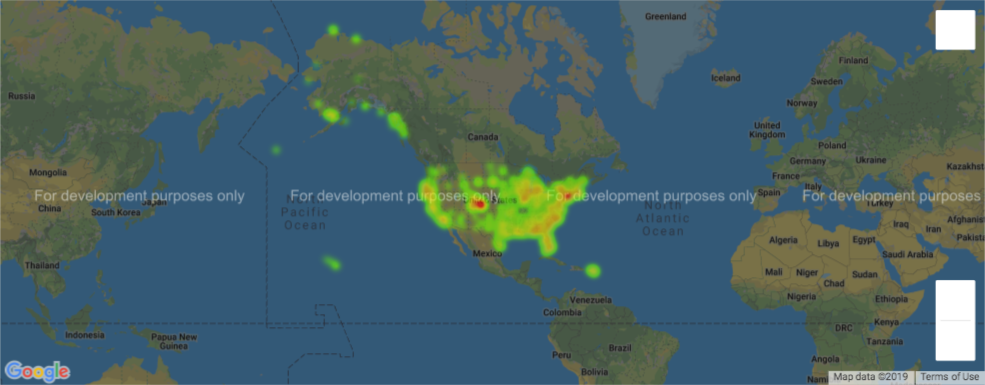

## Recommended Airlines to Avoice Delay & Cancellation

Airlines with minimum rate of delayed & cancelled flightes:-  
`Southwest Airlines` & `US Airways`, `Aloha Airlines`, `Hawaiian Airlines` & `Alaska Airlines`.

Airlines with maximum rate of delayed & cancelled flightes:-  
`American Airlines`, `American Eagle Airlines`, `United Air Lines`, `Expressjet Airlines`, `Mesa Airlines` & `Comair`.

In [0]:
airlines_mean = df.groupby('UniqueCarrier', as_index=False).mean()
airlines_count = df.groupby('UniqueCarrier', as_index=False).count()

airlines = airlines_mean[['UniqueCarrier','ArrDelay','Cancelled']].merge(
    airlines_count[['UniqueCarrier','Year']], on='UniqueCarrier'
)
airlines.rename(columns={'Year':'Count'}, inplace=True)

airlines['Size'] = airlines.Count.map(lambda x: round((x/100000)-.5)+1)
airlines['Size'] = airlines.Size.map(lambda x: 5 if x>5 else x)

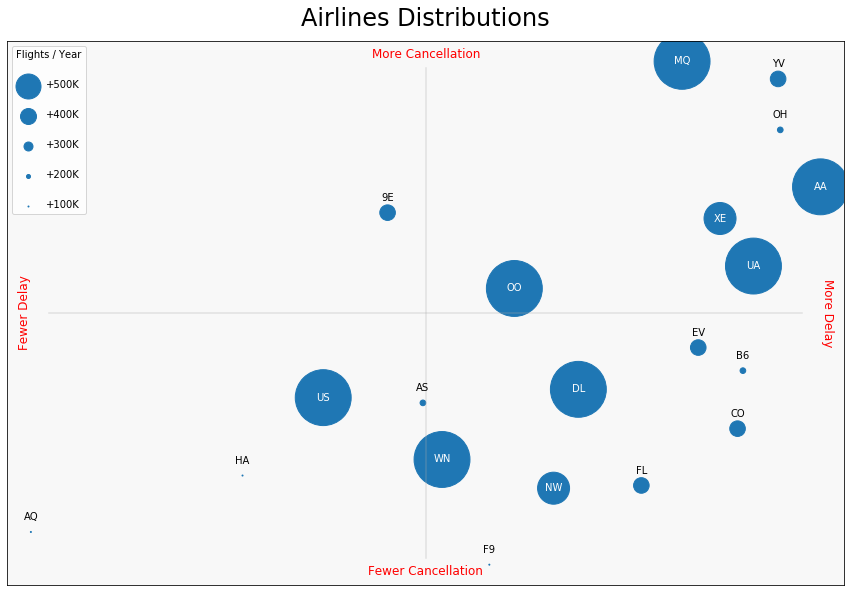

In [0]:


plt.figure(figsize=[15,10])

for size in np.arange(5,0,-1):
    plt.scatter([], [], c='C0', s=size**4, label='+'+ str(size*100) + 'K')
plt.legend(scatterpoints=1,  
           labelspacing=2, 
           frameon=True, 
           title='Flights / Year', 
           mode=2
          )

ax = plt.subplot()
ax.scatter(airlines.ArrDelay, airlines.Cancelled, s=airlines.Size**5, c='C0')

x_max = max(airlines.ArrDelay)
x_min = min(airlines.ArrDelay)

y_max = max(airlines.Cancelled)
y_min = min(airlines.Cancelled)

x_len =  x_max - x_min
y_len =  y_max - y_min

x = x_len*.03
y = y_len*.04

ax.set_xlim(x_min-x, x_max+x)
ax.set_ylim(y_min-y, y_max+y)

ax.axhline(y=y_max-(y_len/2), xmin=.05, xmax=.95, color='darkgray', alpha=.3) 
ax.axvline(x=x_max-(x_len/2), ymin=.05, ymax=.95, color='darkgray', alpha=.3)

ax.text(x_min,y_max-(y_len/2),'Fewer Delay', rotation=90, fontsize=12, color='r', ha='right', va='center')
ax.text(x_max,y_max-(y_len/2),'More Delay', rotation=-90, fontsize=12, color='r', ha='left', va='center')

ax.text(x_max-(x_len/2),y_min,'Fewer Cancellation', rotation=0, fontsize=12, color='r', ha='center', va='top')
ax.text(x_max-(x_len/2),y_max,'More Cancellation', rotation=0, fontsize=12, color='r', ha='center', va='bottom')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.set_facecolor('#f8f8f8')
ax.set_title('Airlines Distributions', fontsize=24, pad=15)

    
for i, name in enumerate(airlines.UniqueCarrier):
    if(airlines.Size[i]>3):
        ax.text(airlines.ArrDelay[i], airlines.Cancelled[i], name, ha='center', va='center', color='w')
    else:
        ax.text(airlines.ArrDelay[i], airlines.Cancelled[i]+.001, name, ha='center', va='center', color='k')

## Recommended Flights Time to Avoice Delay & Cancellation

`AM flights` are cancelled more than `PM flights`, while `PM flights` are more delayed than `AM flights`. 



In [0]:
flights_mean = df.groupby(['FlightNum','DepTimePM'], as_index=False).mean()
flights_count = df.groupby('FlightNum', as_index=False).count()

flights = flights_mean[['FlightNum','DepTimePM', 'DepDelay','Cancelled']].merge(
    flights_count[['FlightNum','Year']], on='FlightNum'
)
flights.rename(columns={'Year':'Count'}, inplace=True)

In [0]:
Q1 = flights.quantile(.25)
Q3 = flights.quantile(.75)
IQ = Q3-Q1
Q_max = Q3+IQ*1.5
Q_min = Q1-IQ*1.5

In [0]:
# ignoring outliers
flights_filtered = flights[(flights.DepDelay > Q_min.DepDelay) & (flights.DepDelay < Q_max.DepDelay)]

flights_filtered = flights_filtered[
    (flights_filtered.Count > Q_min.Count) & (flights_filtered.Count < Q_max.Count)
]

flights_no_cxl = flights_filtered[flights_filtered.Cancelled == 0]
flights_filtered = flights_filtered[flights_filtered.Cancelled > 0]

flights_filtered = flights[flights.Cancelled > 0]
flights_filtered.reset_index(inplace=True)

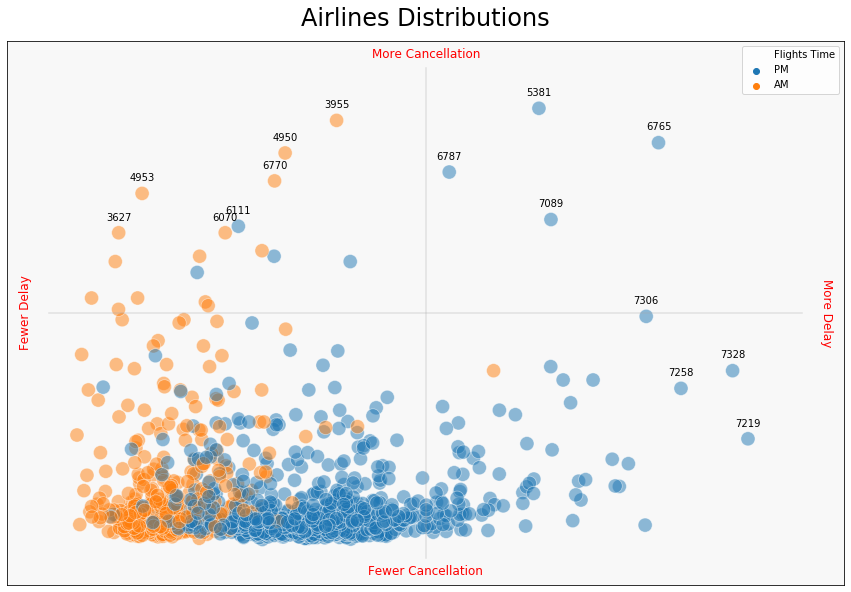

In [0]:
plt.figure(figsize=[15,10])

ax = plt.subplot()

ax = sb.scatterplot(flights_filtered.DepDelay, 
           flights_filtered.Cancelled, 
           hue=flights_filtered.DepTimePM, s=200, alpha=.5)

legend = ax.legend()
legend.texts[0].set_text("Flights Time")

# x_max = max(flights_filtered.DepDelay)
x_max = 50
x_min = min(flights_filtered.DepDelay)

# y_max = max(flights_filtered.Cancelled)
y_max = .03
y_min = min(flights_filtered.Cancelled)

x_len =  x_max - x_min
y_len =  y_max - y_min

x = x_len*.1
y = y_len*.1

ax.set_xlim(x_min-x, x_max+x)
ax.set_ylim(y_min-y, y_max+y)

ax.axhline(y=y_max-(y_len/2), xmin=.05, xmax=.95, color='darkgray', alpha=.3) 
ax.axvline(x=x_max-(x_len/2), ymin=.05, ymax=.95, color='darkgray', alpha=.3)

ax.text(x_min-3.5,y_max-(y_len/2),'Fewer Delay', rotation=90, fontsize=12, color='r', ha='right', va='center')
ax.text(x_max+3.5,y_max-(y_len/2),'More Delay', rotation=-90, fontsize=12, color='r', ha='left', va='center')

ax.text(x_max-(x_len/2),y_min-.0017,'Fewer Cancellation', rotation=0, fontsize=12, color='r', ha='center', va='top')
ax.text(x_max-(x_len/2),y_max+.0017,'More Cancellation', rotation=0, fontsize=12, color='r', ha='center', va='bottom')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.set_facecolor('#f8f8f8')
ax.set_title('Airlines Distributions', fontsize=24, pad=15)

    
for i, name in enumerate(flights_filtered.FlightNum):
    if((flights_filtered.DepDelay[i]>40) & (flights_filtered.DepDelay[i]<x_max)):
        ax.text(flights_filtered.DepDelay[i], 
                flights_filtered.Cancelled[i]+.001, 
                name, ha='center', va='center', color='k'
               )
    elif((flights_filtered.Cancelled[i]>0.02) & (flights_filtered.Cancelled[i]<y_max)):
        ax.text(flights_filtered.DepDelay[i], 
                flights_filtered.Cancelled[i]+.001, 
                name, ha='center', va='center', color='k'
               )
        

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!

In [0]:
# from subprocess import call
# call(['python', '-m', 'nbconvert', 'wrangle_report.ipynb'])

!jupyter nbconvert slide_deck.ipynb --to slides --post serve --template output_toggle

[NbConvertApp] Converting notebook slide_deck.ipynb to slides
[NbConvertApp] Writing 1899711 bytes to slide_deck.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/slide_deck.slides.html
Use Control-C to stop this server
